In [25]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
#
# This file is part of the panco project.
# https://github.com/Huawei-Paris-Research-Center/Panco


In [2]:
from IPython.display import clear_output

import numpy as np
import matplotlib. pyplot as plt

from panco.descriptor.curves import RateLatency, TokenBucket
from panco.descriptor.flow import Flow
from panco.descriptor.server import Server
from panco.descriptor.network import Network

from panco.fifo.tfaLP import TfaLP
from panco.fifo.admTFA import AdmTfa
from panco.fifo.fifoLP import FifoLP

# from PyLPbounds.Blind.blindLP import BlindLP

In [3]:
def delay_shaper(ca, la, cs, ls):
    if ca.sigma < la.sigma: 
        raise Exception('bad formatting')
    if cs.sigma < ls.sigma: 
        raise Exception('bad formatting')
    if cs.rho < ca.rho:
        return np.inf
    tau_a = max((ca.sigma - la.sigma) / (la.rho -  ca.rho), 0)
    fa = ca.sigma + ca.rho * tau_a
    tau_s =  max((cs.sigma - ls.sigma) / (ls.rho -  cs.rho), 0)
    fs = cs.sigma + cs.rho * tau_s
    d_a = max((fa - cs.sigma) / cs.rho, (fa - ls.sigma) / ls.rho) - tau_a
    d_s = tau_s - max((fs - ca.sigma) / ca.rho, (fs - la.sigma) / la.rho)
    d_0 = max((la.sigma - cs.sigma) / cs.rho, (la.sigma - ls.sigma) / ls.rho)
    return max(d_a, d_s, d_0, 0)

# Topology


## Upstream flows

- at each end-station: 4 packets every 1 ms each, length 1kb: arrival curve $\alpha_{es}(t) = 4 \cdot 10^3 + 10^6 t$
- arrivals shaped at 1Gbps: $\sigma_{es}(t) = 10 ^9t$
- 8 end stations: $\alpha_{l} = 8(\alpha_{es} \land \sigma_{es})$
- shaping at the station: $\sigma(t) = b + rt$
- arrival curve after  the station: $\alpha_l \land \sigma$
- shaping at 2 Gbps at ring: $\sigma_{f} = 2\cdot 10^9t$
- arrival curve $\alpha = 8\alpha_{es} \land \sigma \land \sigma_f$. 

***Delay in the admission chip:***
- shaping delay: $hDev(\alpha_l, \sigma\land \sigma_f)$

In [4]:
PACKET = 1000
N_ES = 4
## we assume 4 ES go to each PLC
SIGMA_ES = 4 * N_ES * PACKET

PERIOD = 0.001
RHO_ES = 4 * N_ES * PACKET / PERIOD
SH_ES = N_ES * 10 ** 9
SIGMA = PACKET
U = 1.2
RHO = U * 2 * RHO_ES  # U is a paramater >1
SH_LSW = 2 * 10 ** 9
print(RHO_ES)

16000000.0


In [5]:
ARRIVAL_CURVE_UP = TokenBucket(SIGMA_ES, RHO_ES)
LINK_ES = TokenBucket(PACKET, SH_ES)
SHAPER = TokenBucket(2 * SIGMA, RHO)
LINK_LSW = TokenBucket(PACKET, SH_LSW)

In [6]:
delay_shaper(ARRIVAL_CURVE_UP, LINK_ES, SHAPER, LINK_LSW)

0.0003623870481927711

In [7]:
tab_u = [1 + 0.01 * i for i in range(101)]
tab_shaping_delay = []
for u in tab_u:
    shaper = TokenBucket(SIGMA, u * 2 * RHO_ES)
    tab_shaping_delay += [delay_shaper(ARRIVAL_CURVE_UP, LINK_ES, shaper, LINK_LSW)]


## Downstream flows

In [8]:
SIGMA_D = 2 * PACKET
U_D = 2
RHO_D = U_D * 20 * N_ES * PACKET / PERIOD # (80 packets per period, for each PLC)


## Arrival curves in the ring network

In [9]:
SHAPER_UP = [SHAPER]  
# down: per destination, and not per end-station. this can be modified
ARRIVAL_CURVE_DOWN = TokenBucket(N_ES * PACKET, N_ES * PACKET / PERIOD)
SHAPER_DOWN = [TokenBucket(SIGMA_D, RHO_D)] # global shaper

In [10]:
print(ARRIVAL_CURVE_UP)

16000 + 16000000.0t


In [11]:
print(SHAPER_UP)

[2000 + 38400000.0t]


In [12]:
print(ARRIVAL_CURVE_DOWN)

4000 + 4000000.0t


In [13]:
print(SHAPER_DOWN)

[2000 + 160000000.0t]


## Ring of FPGA

In [14]:
## Servers
NUM_FPGA = 20
FPGA_RATE = 10 ** 9
FPGA_LATENCY = 5 * 10** (-7)
FPGA_SERVER = Server([RateLatency(FPGA_RATE, FPGA_LATENCY)], [TokenBucket(0, FPGA_RATE)])
SERVERS = NUM_FPGA * [FPGA_SERVER]

In [15]:
LIST_SERVERS = list(range(NUM_FPGA))
UP_PATHS = [list(range(i, NUM_FPGA)) for i in range(NUM_FPGA)] +\
           [list(range(i + 1, NUM_FPGA)) + [0] for i in range(NUM_FPGA)]
DOWN_PATHS = [list(range(i + 1)) for i in range(NUM_FPGA)] +\
             [list(range(1, i + 2)) for i in range(NUM_FPGA - 1)] + [list(range(1, NUM_FPGA)) + [0]]

In [16]:
FLOWS_UP = [Flow([ARRIVAL_CURVE_UP], p) for p in UP_PATHS]
FLOWS_DOWN = [Flow([ARRIVAL_CURVE_DOWN], p) for p in DOWN_PATHS]

FLOWS = FLOWS_UP + FLOWS_DOWN

In [17]:
NETWORK = Network(SERVERS, FLOWS)

In [18]:
TFA = TfaLP(NETWORK)
max(TFA.all_delays)

0.0015515628

In [19]:
tab_delay_no_shaping = []
tab_delay_shaping_no_prop = []
tab_delay_shaping_prop = []
for (i,u) in enumerate(tab_u):
    shaper = TokenBucket(SIGMA, u * 2 * RHO_ES)
    ARRIVAL_SHAPING_UP = [(0, [0, 39], [shaper])] + [(i, [i, 19 + i], [shaper]) for i in range(1, 20)]
    ARRIVAL_SHAPING_DOWN = [(0, list(range(40, 60)), SHAPER_DOWN), (1, list(range(60, 80)), SHAPER_DOWN)]
    NETWORK = Network(SERVERS, FLOWS)
    tab_delay_no_shaping += [max(TfaLP(NETWORK).all_delays)]
    NETWORK = Network(SERVERS, FLOWS, ARRIVAL_SHAPING_UP + ARRIVAL_SHAPING_DOWN)
    tab_delay_shaping_no_prop += [max(TfaLP(NETWORK).all_delays)]
    tab_delay_shaping_prop += [max(AdmTfa(NETWORK).all_delays)]
    print('iteration: ', i, '/ ', len(tab_u))
clear_output()

In [20]:
tab_rates = [u * 2 * RHO_ES * 1e-6 for u in tab_u]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


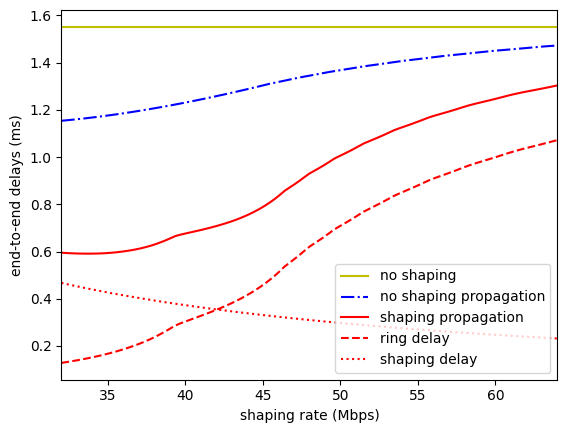

In [21]:
plt.xlabel('shaping rate (Mbps)')
plt.ylabel('end-to-end delays (ms)')
plt.plot(tab_rates, [tab_delay_no_shaping[i] * 1e3 for i in range(len(tab_u))], 'y', label="no shaping")
plt.plot(tab_rates, [tab_delay_shaping_no_prop[i] * 1e3 + tab_shaping_delay[i] * 1e3 for i in range(len(tab_u))], 'b-.', label="no shaping propagation")
plt.plot(tab_rates,  [tab_delay_shaping_prop[i] * 1e3 + tab_shaping_delay[i] * 1e3 for i in range(len(tab_u))], 'r', label="shaping propagation")
plt.plot(tab_rates,  [tab_delay_shaping_prop[i] * 1e3  for i in range(len(tab_u))], 'r--',label="ring delay")
plt.plot(tab_rates, [tab_shaping_delay[i] * 1e3 for i in range(len(tab_u))], 'r:',label="shaping delay")
plt.legend(loc='lower right')
plt.xlim([32, 64])
plt.savefig('ring2f.eps', format='eps')
plt.show()

In [22]:
NETWORK = Network(SERVERS, FLOWS)
TFA = TfaLP(NETWORK)
max(TFA.all_delays)

0.0015515628

In [23]:
NETWORK = Network(SERVERS, FLOWS, ARRIVAL_SHAPING_UP + ARRIVAL_SHAPING_DOWN)
TFA = TfaLP(NETWORK)
max(TFA.all_delays)

0.0012413582000000002

In [24]:
TFA = AdmTfa(NETWORK)
max(TFA.all_delays)

0.0010720927